Exercício preparatório para o CP2

1-  O seu desafio é criar um modelo de classificação de imagens para detecção de tumor cerebral. Crie um modelo utilizando camadas CNN e densas. Treine o modelo do zero. Os dados para a realização do exercíco estão em:

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

2- Utilize os pesos de um modelo pretreinado (como o exemplo da aula anterior quando usamos os pesos da VGG) para fazer transfer learning, e treine apenas as camadas finais do modelo.

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers

In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
path_No = '/content/drive/MyDrive/IA Generativa/archive/no/*'
path_Yes = '/content/drive/MyDrive/IA Generativa/archive/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))

all_data = tumor + no_tumor

data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

In [4]:
print(tumor)

[(array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8), 1), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

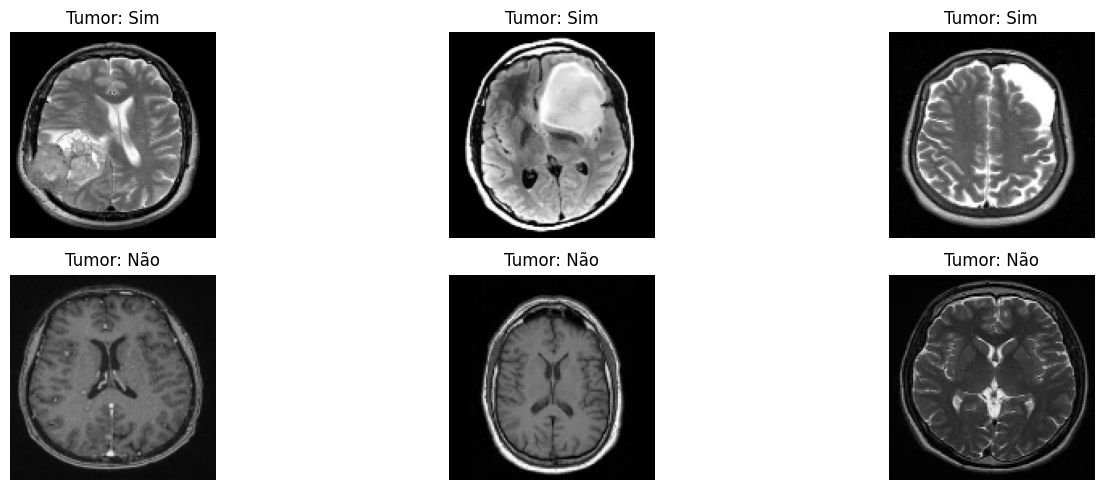

In [5]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Sim")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: Não")
    plt.axis('off')

plt.tight_layout()
plt.show()

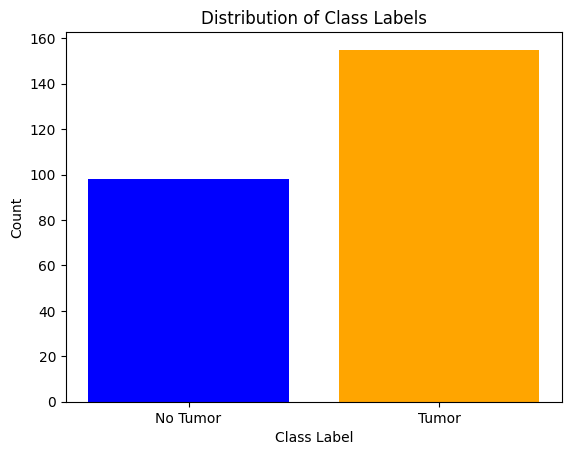

In [6]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [7]:
def crop_brain_region(image, size):

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    c = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(c)

    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)

    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)

    cropped_image = image[y:y+h, x:x+w]

    resized_image = cv2.resize(cropped_image, size)

    return contour_image, bounding_box_image, cropped_image, resized_image

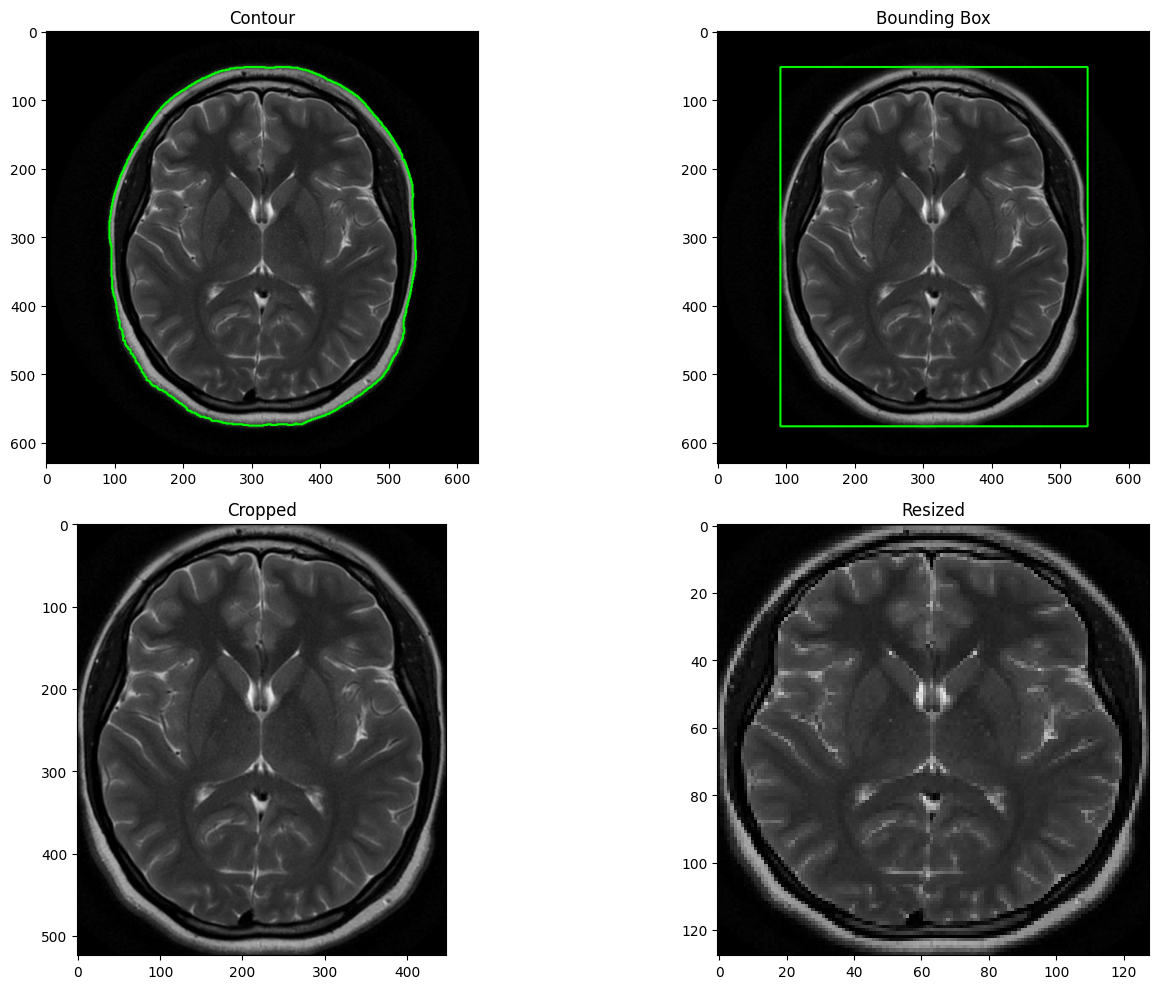

In [8]:
output_size = (128, 128)

example_image = cv2.imread('/content/drive/MyDrive/IA Generativa/archive/brain_tumor_dataset/no/1 no.jpeg')
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2, 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in data:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)

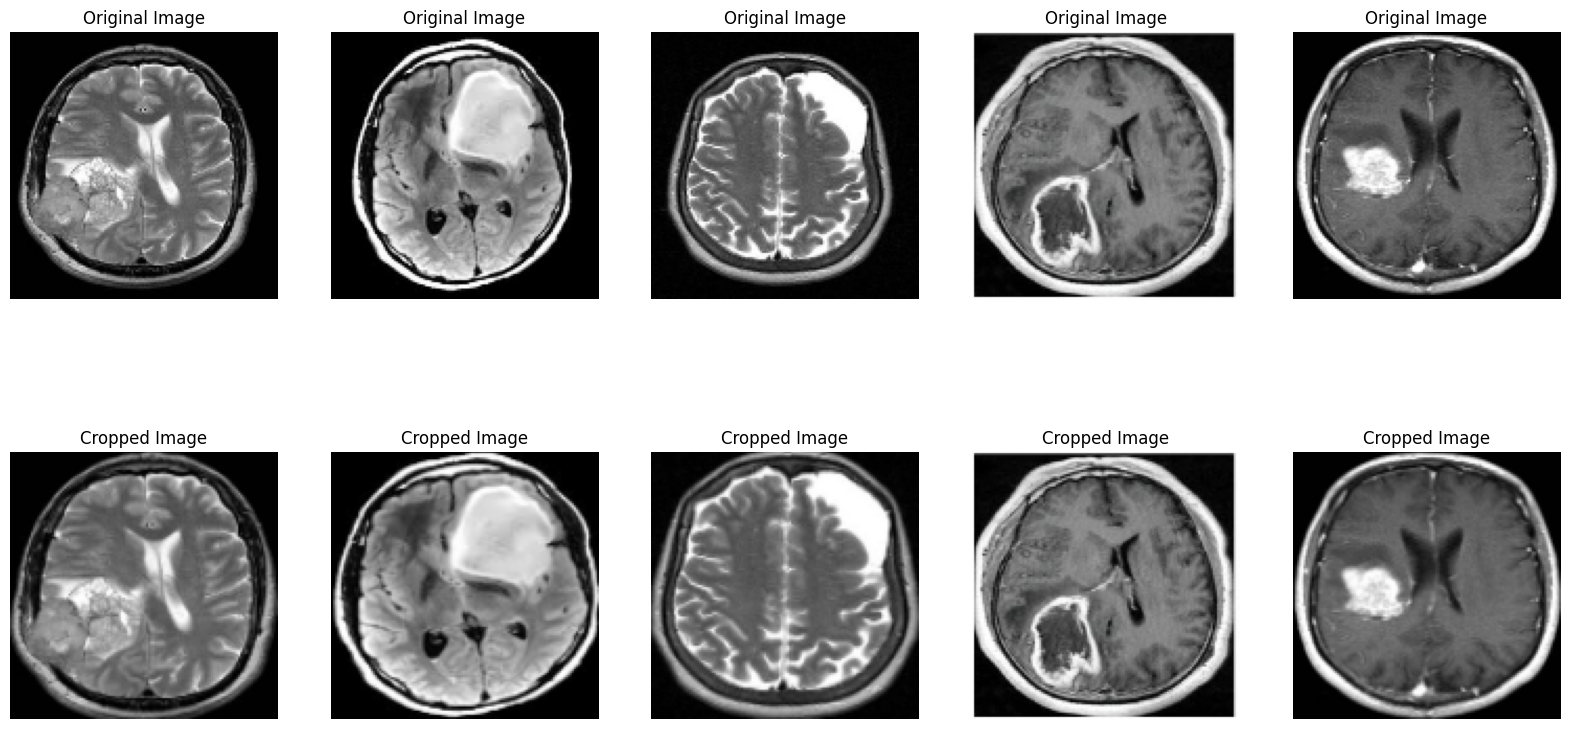

In [9]:
num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(data[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()

In [10]:
all_cropped=np.array(all_cropped)

In [11]:
all_cropped_shuffled, labels_shuffled = shuffle(all_cropped, labels, random_state=42)

train_images, test_images, train_labels, test_labels = train_test_split(all_cropped_shuffled, labels_shuffled, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (202, 128, 128, 3)
Train labels shape: (202,)
Validation data shape: (26, 128, 128, 3)
Validation labels shape: (26,)
Test data shape: (25, 128, 128, 3)
Test labels shape: (25,)


In [12]:
print(np.max(train_images))
print(np.min(train_images))

255
0


In [13]:
train_images=train_images/255
test_images=test_images/255
val_images=val_images/255

In [14]:
print(np.max(train_images))
print(np.min(train_images))

1.0
0.0


In [15]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [16]:
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(patience=5, monitor='val_loss')


history = model.fit(train_images,
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                   callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 19s 2s/step - loss: 0.6815 - accuracy: 0.5495 - val_loss: 0.6305 - val_accuracy: 0.6923
Epoch 2/50
7/7 [==============================] - 13s 2s/step - loss: 0.6547 - accuracy: 0.6089 - val_loss: 0.6050 - val_accuracy: 0.6923
Epoch 3/50
7/7 [==============================] - 6s 836ms/step - loss: 0.6592 - accuracy: 0.6089 - val_loss: 0.6045 - val_accuracy: 0.6923
Epoch 4/50
7/7 [==============================] - 7s 1s/step - loss: 0.6412 - accuracy: 0.6089 - val_loss: 0.6124 - val_accuracy: 0.6923
Epoch 5/50
7/7 [==============================] - 6s 839ms/step - loss: 0.6505 - accuracy: 0.6089 - val_loss: 0.6156 - val_accuracy: 0.6923
Epoch 6/50
7/7 [==============================] - 7s 1s/step - loss: 0.6358 - accuracy: 0.6188 - val_loss: 0.6023 - val_accuracy: 0.6923
Epoch 7/50
7/7 [==============================] - 7s 861ms/step - loss: 0.6194 - accuracy: 0.6139 - val_loss: 0.5902 - val_accuracy: 0.6923
Epoch 8/50
7/7 [==============

1/1 [==============================] - 1s 539ms/step
Accuracy on Validation Set: 0.846 %


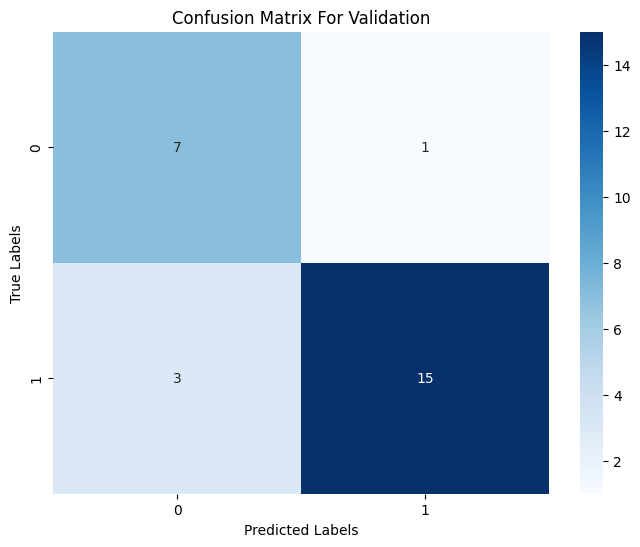

In [17]:
predictions = model.predict(val_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

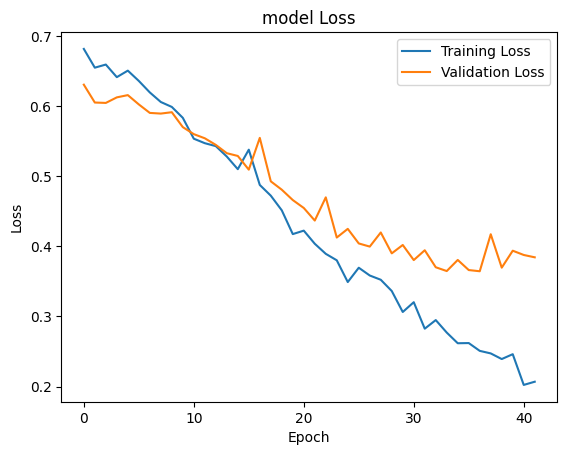

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 174ms/step
Accuracy on Test Set: 0.800 %


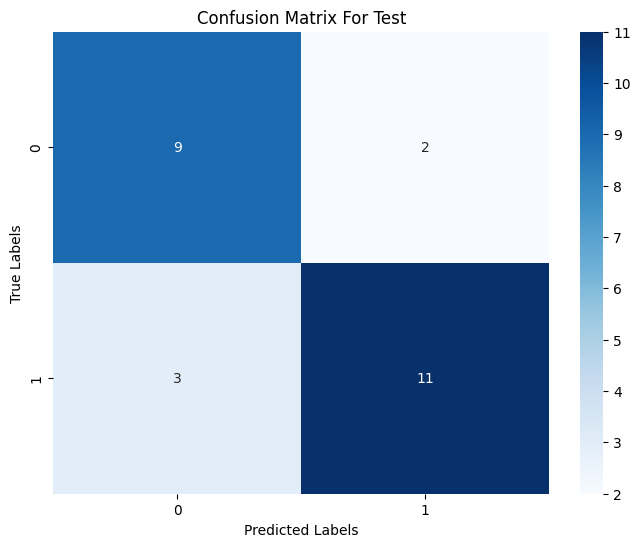

In [19]:
predictions = model.predict(test_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

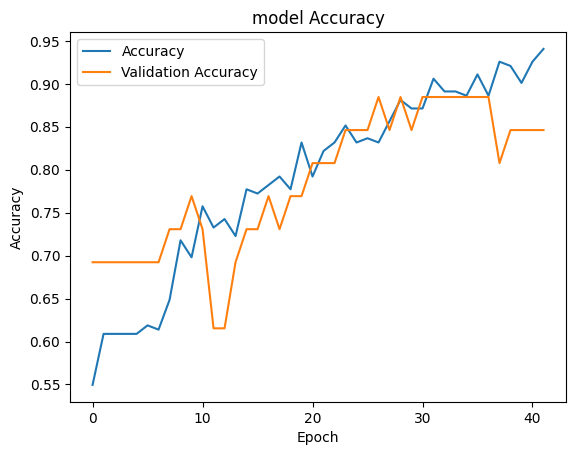

In [20]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    train_images, train_labels,
    batch_size=32
)

val_generator = val_datagen.flow(
    val_images, val_labels,
    batch_size=32
)

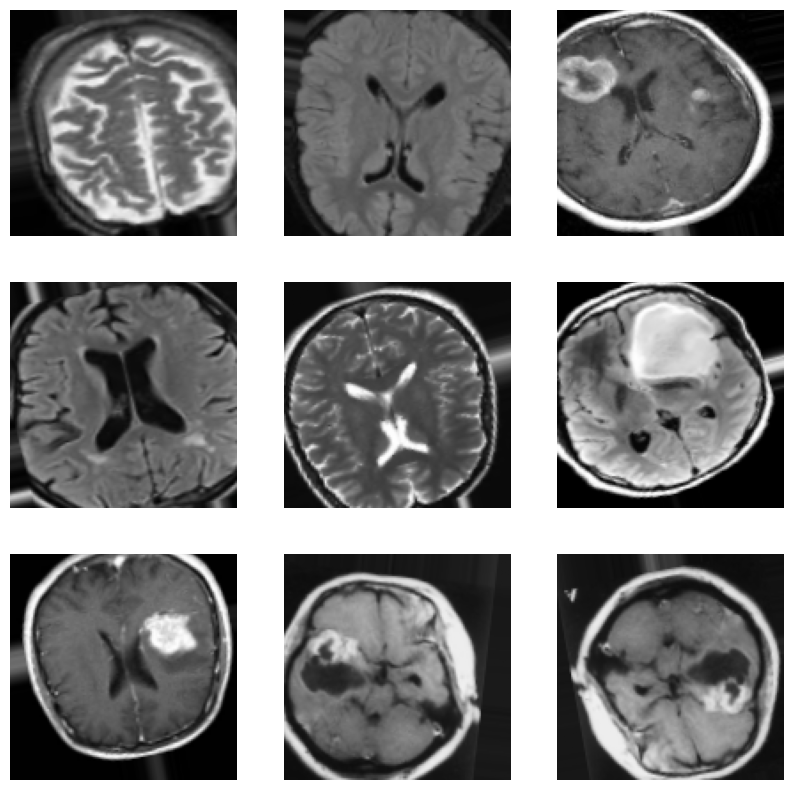

In [22]:
augmented_images = train_datagen.flow(train_images, train_labels, batch_size=32)

augmented_images_batch, _ = next(augmented_images)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images_batch[i])
    plt.axis('off')
plt.show()